In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.utils import resample

## Introduction
I will be using the CES11 data from R datasets. This is part of a survey on canadian voters on whether or not they
support banning abortion. This data set is all categorical except for one column, population which contains information on
the population of the city or province the respondent lives in. The other non categorical column is the weight column, which
contains values representing weight sample to size of population, taking into account unequal sampling probabilities by
province and household size. For the purposes of this analysis we won't worry about that one.

### province
a factor with (alphabetical) levels AB, BC, MB, NB, NL, NS, ON, PE, QC, SK; the sample was stratified by province

### population
population of the respondent's province, number over age 17

### weight
weight sample to size of population, taking into account unequal sampling probabilities by province and household size.

### gender
a factor with levels Female, Male.

### abortion
attitude toward abortion, a factor with levels No, Yes; answer to the question "Should abortion be banned?"

### importance
importance of religion, a factor with (alphabetical) levels not, notvery, somewhat, very; answer to the question, "In your life, would you say that religion is very important, somewhat important, not very important, or not important at all?"

### education
a factor with (alphabetical) levels bachelors (Bachelors degree), college (community college or technical school), higher (graduate degree), HS (high-school graduate), lessHS (less than high-school graduate), somePS (some post-secondary)

### urban
place of residence, a factor with levels rural, urban.

In [26]:
url = "https://vincentarelbundock.github.io/Rdatasets/csv/carData/CES11.csv"
CES11_df = pd.read_csv(url)

## Exploring the data

In [27]:
CES11_df.head(10)

,Unnamed: 0,id,province,population,weight,gender,abortion,importance,education,urban
0,1,2851,BC,3267345,4287.85,Female,No,somewhat,somePS,urban
1,2,521,QC,5996930,9230.78,Male,No,not,bachelors,urban
2,3,2118,QC,5996930,6153.85,Male,Yes,somewhat,college,urban
3,4,1815,NL,406455,3430.00,Female,No,very,somePS,urban
4,5,1799,ON,9439960,8977.61,Male,No,not,higher,rural
5,6,1103,ON,9439960,8977.61,Female,No,not,higher,urban
6,7,957,NL,406455,3430.00,Female,Yes,very,lessHS,rural
7,8,3431,NL,406455,1715.00,Female,Yes,notvery,college,urban
8,9,2516,NL,406455,1715.00,Male,No,very,college,urban
9,10,959,NL,406455,3430.00,Male,Yes,very,lessHS,rural


In [28]:
CES11_df.shape

(2231, 10)

In [29]:
CES11_df.dtypes

Unnamed: 0      int64
id              int64
province       object
population      int64
weight        float64
gender         object
abortion       object
importance     object
education      object
urban          object
dtype: object

## Cleaning the data
Drop the unnamed category, this is going to create an issue later. We are also going to drop the id column, since this
column isn't going to give us any additional information and might confuse whatever model we use in the future.
Since most of the categories are categorical we will convert these to a integer representation, to make using in machine learning models easier.

In [30]:
CES11_df.drop('Unnamed: 0', axis=1, inplace=True)
CES11_df.drop('id', axis=1, inplace=True)

In [31]:
CES11_df_2 = CES11_df.replace({'province' :{'AB':0,'BC':1,'MB':2,'NB':3,'NL':4,'NS':5,'ON':6,'PE':7,'QC':8,'SK':9},
                             'gender':{'Male':0, 'Female':1},
                             'importance' : {'not':0,'notvery':1,'somewhat':2,'very':3},
                             'education' : {'bachelors':0,'college':1, 'higher':2, 'HS' :3, 'lessHS':4,'somePS':5},
                             'urban' : {'urban' : 0,'rural' :1}})
CES11_df_2.head(10)

,province,population,weight,gender,abortion,importance,education,urban
0,1,3267345,4287.85,1,No,2,5,0
1,8,5996930,9230.78,0,No,0,0,0
2,8,5996930,6153.85,0,Yes,2,1,0
3,4,406455,3430.00,1,No,3,5,0
4,6,9439960,8977.61,0,No,0,2,1
5,6,9439960,8977.61,1,No,0,2,0
6,4,406455,3430.00,1,Yes,3,4,1
7,4,406455,1715.00,1,Yes,1,1,0
8,4,406455,1715.00,0,No,3,1,0
9,4,406455,3430.00,0,Yes,3,4,1


In [32]:
# Display value counts
CES11_df_2.abortion.value_counts()

No     1818
Yes     413
Name: abortion, dtype: int64

### Boosting the data
This is a hugely imbalanced dataset, no's makeup about 80% of the dataset. This means it is going to be a little more
difficult to make a machine learning model better than simply pure guessing. To improve the quality of a machine learning
model we will boost our dataset using a basic upsampling technique. I start by separating the majority value and minority
value into two separate datasets, and then use the resample method available in sklearn to randomly create possible minority
data entrys.

In [33]:
df_maj = CES11_df_2[CES11_df_2.abortion == 'No']
df_min = CES11_df_2[CES11_df_2.abortion == 'Yes']
print("The majority sample size is: {}".format(len(df_maj)))



The majority sample size is: 1818


In [34]:
# Upsample majority class
df_min_up = resample(df_min, replace=True,    # sample without replacement
                             n_samples=1818,     # to match minority class
                             random_state=1)
# Combine minority class with downsampled majority class
CES11_df_2 = pd.concat([df_min_up, df_maj])

# Display new class counts
CES11_df_2.abortion.value_counts()

Yes    1818
No     1818
Name: abortion, dtype: int64

After cleaning the data we are left with a data frame of 3638 rows and 8 columns. Our
target will be the abortion column, and the features will be everything else.

## Visualize the data
Let's Visualize our data. The plan is to make a model to predict whether a Canadian voter supports or opposes
banning abortion, so that will be our hue.

<AxesSubplot:>

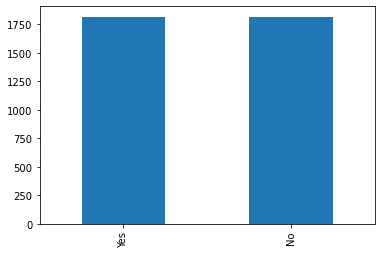

In [35]:
CES11_df_2['abortion'].value_counts().plot(kind='bar')

### Pair plot

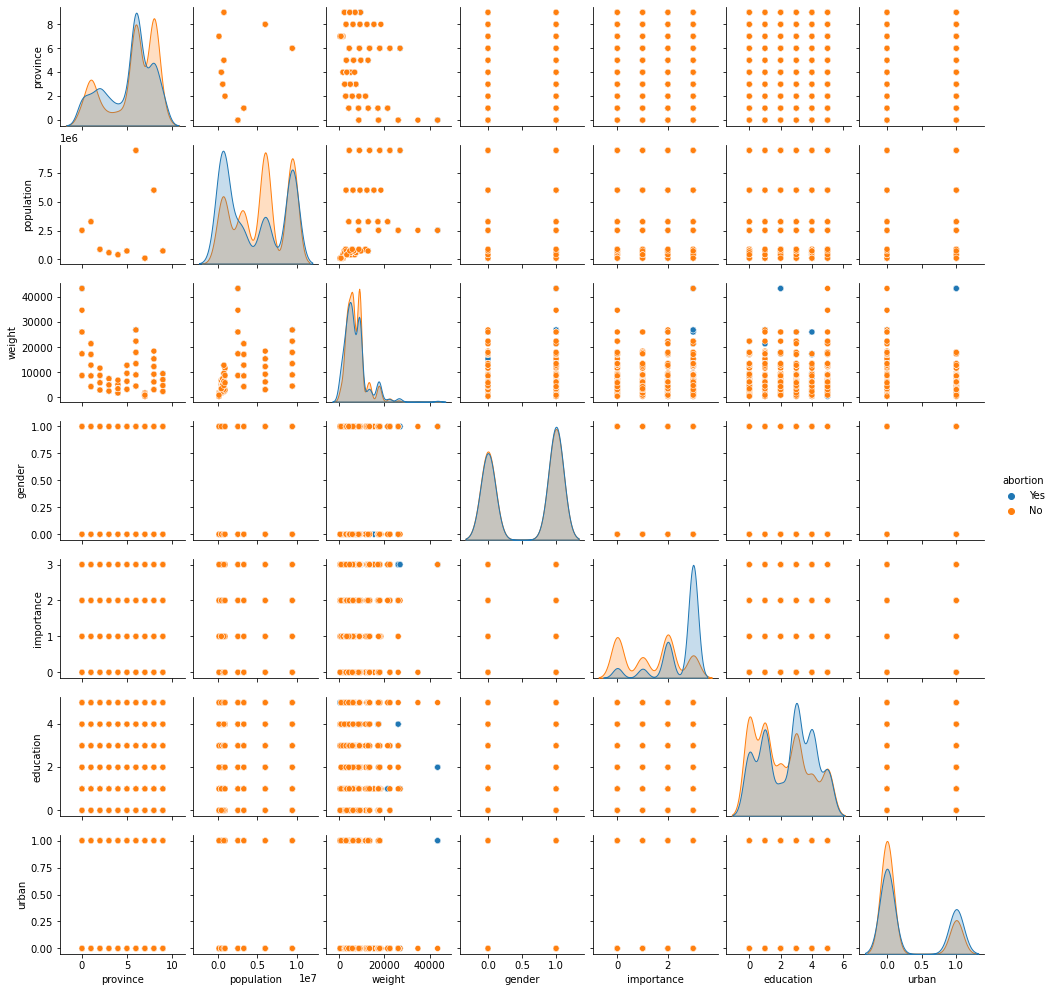

In [36]:
sns.pairplot(CES11_df_2, hue='abortion', height=2)

In addition to the imbalance of the abortion column, there are not a lot of clear places we could draw a clear dividing
line without potentially over fitting our data

## Next Steps
After looking at the summary statistics for the dataset I have a couple questions I think we could potentially answer.
The first is whether a particular characteristic is valuable for predicting a person's stance on banning abortion.
To solve this question I think a decision tree would be the best model to use, because we can very clearly see the
columns the model is using. I would also like to test this on an SVM. Because this is a difficult data set interms of balance
I would like to see which model performs better.

### Question 1: Can we predict whether a respondent supports Abortion or not using a decision tree?

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score
from treeprint import tree_print
from confidence import classification_confint
from sklearn.metrics import confusion_matrix

In [38]:
targets = pd.DataFrame(CES11_df_2['abortion'])
features = CES11_df_2.drop('abortion', axis=1)

In [39]:
model = model = tree.DecisionTreeClassifier()
param_grid = {
    'max_depth': list(range(1,11)), # search 1..10
    'criterion': ['entropy', 'gini']
    }
grid = GridSearchCV(model, param_grid, cv=5)

In [40]:
grid.fit(features,targets)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [41]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'criterion': 'gini', 'max_depth': 10}


In [42]:
print("Best tree:")
tree_print(grid.best_estimator_,features)

Best tree:
if importance =< 2.5: 
  |then if importance =< 1.5: 
  |  |then if education =< 2.5: 
  |  |  |then if weight =< 2696.9200439453125: 
  |  |  |  |then if province =< 8.0: 
  |  |  |  |  |then if weight =< 1088.2750244140625: 
  |  |  |  |  |  |then No
  |  |  |  |  |  |else if education =< 1.5: 
  |  |  |  |  |  |  |then if gender =< 0.5: 
  |  |  |  |  |  |  |  |then if province =< 3.5: 
  |  |  |  |  |  |  |  |  |then Yes
  |  |  |  |  |  |  |  |  |else No
  |  |  |  |  |  |  |  |else if province =< 3.5: 
  |  |  |  |  |  |  |  |  |then No
  |  |  |  |  |  |  |  |  |else Yes
  |  |  |  |  |  |  |else No
  |  |  |  |  |else No
  |  |  |  |else if weight =< 16268.02490234375: 
  |  |  |  |  |then if importance =< 0.5: 
  |  |  |  |  |  |then if weight =< 4605.3349609375: 
  |  |  |  |  |  |  |then No
  |  |  |  |  |  |  |else if weight =< 5991.505126953125: 
  |  |  |  |  |  |  |  |then if gender =< 0.5: 
  |  |  |  |  |  |  |  |  |then if weight =< 5393.8349609375: 
  |  |

In [43]:
predict_target = grid.best_estimator_.predict(features)

In [44]:
acc = accuracy_score(targets, predict_target)

In [45]:
observations = CES11_df_2.shape[0]
lb,ub = classification_confint(acc, observations)
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

# buld confusion matrix
labels = ['No', 'Yes']
cm2 = confusion_matrix(targets, predict_target, labels=labels)
cm_df2 = pd.DataFrame(cm2, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(cm_df2))

Accuracy: 0.84 (0.83,0.85)
Confusion Matrix:
       No   Yes
No   1443   375
Yes   210  1608


Our model is between 83 and 85 percent accurate which is
fairly successful in my opinion especially considering the
lack of clear divides in this situation.
This ended up being a very complicated decision tree model, but ultimately I feel confident that this model would do a good
job of predicting

### Question 2: Will an SVM do this classification better?

In [46]:
from sklearn.svm import SVC


In [47]:
# SVM
model2 = SVC(coef0=1.0, max_iter=10000)
param_grid2 = [{'C': [0.1, 0.5, 1], 'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma' : ['scale', 'auto']}]
grid2 = GridSearchCV(model2, param_grid2, cv=5)
grid2.fit(features, targets)
print("Grid Search: best parameters: {}".format(grid2.best_params_))

C:\Users\nickp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\nickp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\nickp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\nickp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

Grid Search: best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [48]:
# evaluate the best model
best_model2 = grid2.best_estimator_
predict_y2 = best_model2.predict(features)
acc2 = accuracy_score(targets, predict_y2)
lb2,ub2 = classification_confint(acc2,features.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc2,lb2,ub2))

# build confusion matrix
labels = ['No', 'Yes']
cm2 = confusion_matrix(targets, predict_y2, labels=labels)
cm_df2 = pd.DataFrame(cm2, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(cm_df2))

Accuracy: 0.81 (0.80,0.82)
Confusion Matrix:
       No   Yes
No   1442   376
Yes   316  1502


### Analysis
These results are interesting for a couple of reasons.
The first is that the decision tree was ultimately a better predictor of whether a canadian voter supports
abolishing abortion or not. This difference was statistically significant because there was no overlap in the confidence
intervals of the two models. However, both models are fairly good at predicting whether a canadian supports banning abortion
or not. It should be stated that our method of upsampling is potentially prone to over fitting data, and our method does not
take into account generating outliers, and only generated options within the realm of possibility.